In [ ]:
import soundfile as sf
import resampy
import numpy as np
import matplotlib.pyplot as plt

target_sample_rate = 16000  # Set the sample rate to which you want to downsample.

# Read the audio files and resample them.
signal1, sample_rate1 = sf.read("output4.wav")
signal1_resampled = resampy.resample(signal1, sample_rate1, target_sample_rate)

signal2, sample_rate2 = sf.read("output4/output4/vocals.wav")

signal2_resampled = resampy.resample(signal2[:,0], sample_rate2, target_sample_rate)

# Compute the difference
difference = signal1_resampled - signal2_resampled

# Generate time axis values
time1 = np.linspace(0., len(signal1_resampled)/target_sample_rate, len(signal1_resampled))
time2 = np.linspace(0., len(signal2_resampled)/target_sample_rate, len(signal2_resampled))
time_diff = np.linspace(0., len(difference)/target_sample_rate, len(difference))

plt.figure()

# Plot signal 1
plt.subplot(3, 1, 1)
plt.plot(time1, signal1_resampled)
plt.title("file1.wav")

# Plot signal 2
plt.subplot(3, 1, 2)
plt.plot(time2, signal2_resampled)
plt.title("file2.wav")

# Plot the difference
plt.subplot(3, 1, 3)
plt.plot(time_diff, difference)
plt.title("difference")

plt.tight_layout()
plt.show()

In [ ]:
from spleeter.separator import Separator
import numpy as np
import scipy.signal as sg
import soundfile as sf

# Using embedded configuration.
separator = Separator('spleeter:2stems')

# # Using custom configuration file.

def load_audio(filepath, sr=None, mono=True, dtype='float8'):
    
    x, fs = sf.read(filepath)

    if mono and len(x.shape)>1:
        x = np.mean(x, axis = 1)
    if sr:
        x = sg.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)

    return x, fs

# # Original wav track after spleeter
x, fr = load_audio('output4.wav')
x = np.array(x,ndmin = 2)
x = np.transpose(x)
np.shape(x)

import time


t = time.time()
res = separator.separate(x)
print(time.time() - t)
np.shape(res['vocals'][:,0])
x = np.transpose(x)[0]
x1 = res['vocals'][:,0]
print(np.shape(x), np.shape(x1))
norm_cross_corr = scipy.signal.correlate(x, x1, mode='valid')
norm = np.sqrt(np.sum(x ** 2) * np.sum(x1 ** 2))
if norm != 0:
    norm_cross_corr /= norm
similarity = np.max(np.abs(norm_cross_corr))
print('similarity:', similarity)



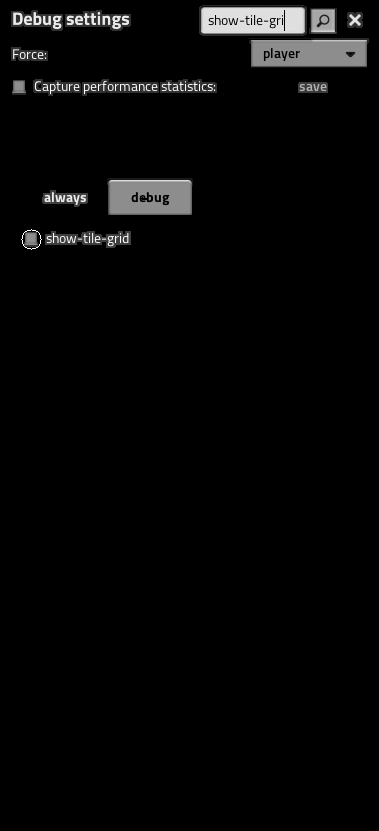

In [13]:
import cv2 as cv
import numpy as np

im = cv.imread('../tmp/test_open_debug_options_im.bmp')

im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
_, d = cv.threshold(im, 128, 255, cv.THRESH_BINARY)
d = dilate(d, 2, cv.MORPH_RECT)
im = cv.bitwise_and(im, im, mask=d)
ccs = get_ccs(d, with_br=True)
h, w = d.shape
p = np.array((0, h))
srt = sorted(ccs, key=lambda x: np.linalg.norm(p - Rect(*x[1]).xy()))
c = Rect(*srt[0][1]).center()
cv.circle(im, c, 10, 255, 1)
dis(im)

In [8]:
'''
this snippet shows how to select belts
'''

import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
# import common
from common import *
from sklearn.cluster import KMeans

alpha = 0.001
bg = cv.imread('../tmp/test_get_tooltip1_bg.bmp')
bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
def get_foreground(bg, comp):
    im = comp.copy()
    # im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    comp = comp.astype(np.float32)
    bg = bg.astype(np.float32)
    fg = (comp - bg)
    fg = np.clip(fg, 0, 255).astype(np.uint8)
    # fg = cv.cvtColor(fg, cv.COLOR_BGR2RGB)
    fg = posterize_blk(fg, 5)
    return fg

fg = get_foreground(bg, comp)
# dis(fg)
vl, hl, mvl, mhl, gw = get_grid(comp, grid_color=(32,32,32))
xy = grid(vl, hl)
# print(xy)
# import itertools
dd = {}
coords = {}


marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')
marks = cv.cvtColor(marks, cv.COLOR_BGR2GRAY)
ents, ents1 = get_entity_coords_from_marks(marks, comp.astype(np.uint8), grid_color=(32,32,32))

map_c_to_e = {}
for e in ents1:
    map_c_to_e[e.top_left] = e.size
    # print(e.top_left)
#

gw, gh, _ = xy.shape

# for i in range(gw):
    # for j in range(gh):

bmap = np.array([['_'] * gh] * gw)

# print(bmap)
for i, (x, y) in enumerate(itertools.product(vl, hl)):
    # x, y = xy[(i, j)]
    w = 32
    ww = 20

    ii = i // len(vl)    
    jj = i % len(vl)

    c = get_cell_at(fg, (x,y), 32)
    cc = crop_image(c, Rect(w//2-ww//2, w//2-ww//2, ww,ww))
    cnt = np.count_nonzero(cc != (0,0,0))
    if cnt > 32 * 1:
        d = ((cc != (0,0,0)) * 100).astype(np.uint8)
        # print(i)
        # dis(c, msk)
        rr = Rect(w//2-ww//2,w//2-ww//2, ww, ww)
        cw = crop_image(c, rr)
        dd[i] = [c, cv2.GaussianBlur(cw, (3,3), 0, 0).astype(np.float32)]
        coords[i] = (x, y)
        # putOutlinedText(im, f'{ii}, {jj}', (x+2, y + 16), sz=0.35)
        putOutlinedText(fg, f'{i}', (x+2, y + 16), sz=0.35)
        cf = cw.astype(np.float32)
        cgf = cv.cvtColor(cv.cvtColor(cw, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB).astype(np.float32)
        res = np.clip(cf - cgf, 0, 256).astype(np.uint8)
        _, res = cv.threshold(res, 20, 255, cv.THRESH_BINARY)
        cnt = np.count_nonzero(res)
        # putOutlinedText(im, str(cnt), (x+2, y + 16), sz=0.35)
        h, w, _ = cw.shape
        gr = cv.cvtColor(cw, cv.COLOR_RGB2GRAY)
        # dis(gr)
        cntblk = h * w - cv.countNonZero(gr)
        # cntblk = np.count_nonzero(c)
        cntgry, gmsk = count_gray_pixels1(cw, threshold=20)

        # if (cntgry - cntblk) / (h*w) > 0.68:
        col, cnum = get_prevalent_color(cw)

        ddd = {
            'top-left-ccw': 'tlc',
            'top-left-cw': 'tl',
            'top-right-ccw': 'trc',
            'top-right-cw': 'tr',
            'bottom-left-ccw': 'blc',
            'bottom-left-cw': 'bl',
            'bottom-right-ccw': 'brc',
            'bottom-right-cw': 'br',
            'up': 'u',
            'down': 'd',
            'left': 'l',
            'right': 'r',
            None: 'nnn'
        }

        if col == (25,25,25):
            # putOutlinedText(fg, str(cnum), (x+2, y + 16), sz=0.35)
            if cnum >= 275:
                if (ii, jj) in map_c_to_e:
                    sz = map_c_to_e[(ii, jj)]
                    if sz.tolist() == [1,1]:
                        # cv.circle(fg, (x+16, y+16), 11, (128,128,128), 1)
                        d = classify_image(c)
                        # print(d)
                        if d in map_corner_to_dir:
                            d = corner_to_dir(d)
                        bmap[jj][ii] = d[0]
                        # print(f'{jj},{ii},{d[0]}')
                        putOutlinedText(fg, f'{d[0]}', (x+10, y + 16), sz=0.35)
                        pass
                pass

        # cols = frozenset(tuple(pixel) for row in cw for pixel in row)

        # if len(cols.difference(belt_colors)) < 4:
            # cv.circle(im, (x+16, y+16), 3, (255,0,0), 1)
    # cell_loc()
    # cv.circle(im, (x, y), 3, (255,255,255), 1)


def is_similar(cell_dict, indx1, indx2):

    # assert img1.shape == img2.shape
    # h, w, _ = img1.shape
    # assert w == h
    # img1 = cv2.GaussianBlur(img1, (3,3), 0, 0)
    # img2 = cv2.GaussianBlur(img2, (3,3), 0, 0)
    # img1 = img1.astype(np.float32)
    # img2 = img2.astype(np.float32)
    img1, img2 = cell_dict[indx1][1], cell_dict[indx2][1]

    img11, img22 = cell_dict[indx1][0], cell_dict[indx2][0]

    c1 = frozenset(tuple(pixel) for row in img11 for pixel in row)
    c2 = frozenset(tuple(pixel) for row in img22 for pixel in row)
    # print(sorted(list(c1)))
    # print(sorted(list(c2)))
    max(len(c1), len(c2))
    c3 = c1.union(c2)
    print(len(c3), len(c2), len(c1))

    msk1 = np.clip(img2 - img1, 0, 255).astype(np.uint8)
    _, msk1 = cv.threshold(msk1, 20, 255, cv.THRESH_BINARY)
    cnt1 = np.count_nonzero(msk1)
    msk2 = np.clip(img1 - img2, 0, 255).astype(np.uint8)
    _, msk2 = cv.threshold(msk2, 20, 255, cv.THRESH_BINARY)
    cnt2 = np.count_nonzero(msk2)
#   # print(max(cnt1, cnt2))
    # dis(msk1, msk2, img1.astype(np.uint8), img2.astype(np.uint8))
    h, w, _ = msk2.shape
    diff = max(cnt1, cnt2)
    similar_rate = (h * w - diff) / (h * w)
    # print(similar_rate)


    return similar_rate >= 0.7

lst = [364, 362, 363, 556, 392]
lst = [364, 686, 782]
lst = [685, 686, 717, 718, 781, 782, 813, 814, 422, 364, 432]
# lst = [685, 781]
# lst = [717, 813]
# lst = [686,782]
lst = [718, 814]
lst = [428, 429]
# lst = [166, 171]
# imgs = [dd[idx][0] for idx in lst]


""" for img, idx in zip(imgs, lst):
    print(classify_image(img))
    print(idx)
    dis(img)
    # break
 """

# qwe = [''.join(r) for r in bmap]
# print('\n'.join(qwe))
s = '\n'.join([''.join(row.tolist()) for row in bmap])
    

print(s)
dis(dd[498][1])



___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________


TypeError: Cannot handle this data type: (1, 1, 3), <f4

32
[89, 5, 139, 110]
414


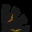

[89, 5, 139, 110]
[89, 5, 139, 110]
________________________
________________________
________________________
_______u________________
_______u__d_dllllll_____
_______u__d_d_____u_____
_______u__d_rrrrrdu_____
_______u__d_dlllllu_____
______rul_d_rrrrrdu_____
______uuu_d______du_____
______uuu_d__lllllu_____
______u_u_d_______u_____
______u_u_rrrrrrrru_____
______u_u_______________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________


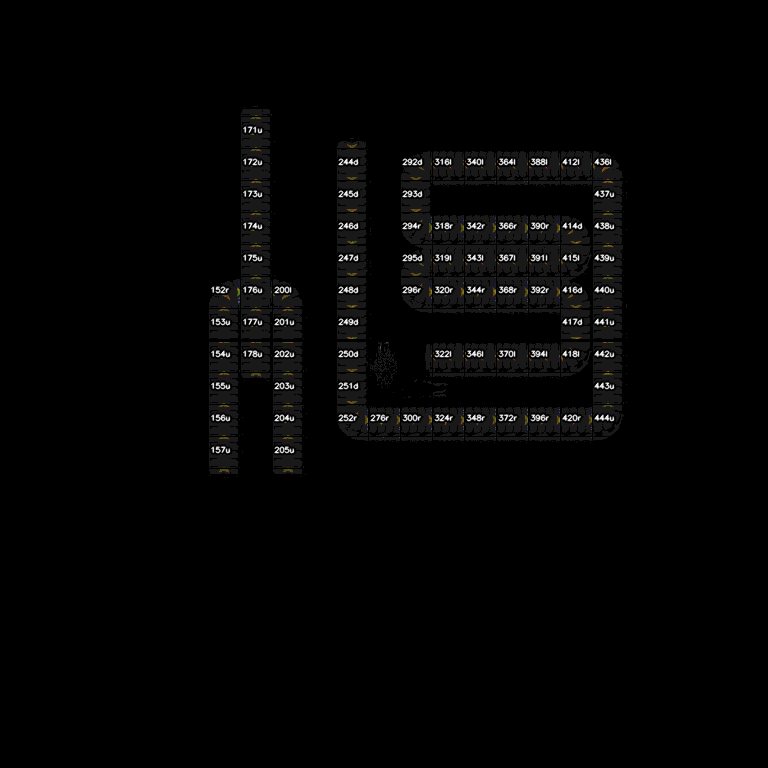

In [63]:
'''
this snippet shows how to select belts
'''

import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
import common
from common import *
from npext import *
from sklearn.cluster import KMeans

alpha = 0.001
bg = cv.imread('../tmp/test_get_tooltip1_bg.bmp')
comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
# dis(comp)
def get_foreground(bg, comp):
    im = comp.copy()
    # im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    comp = comp.astype(np.float32)
    bg = bg.astype(np.float32)
    fg = (comp - bg)
    fg = np.clip(fg, 0, 255).astype(np.uint8)
    # fg = cv.cvtColor(fg, cv.COLOR_BGR2RGB)
    fg = posterize_blk(fg, 5)
    return fg

fg = get_foreground(bg, comp)
# dis(fg)

vl, hl, mvl, mhl, gcw = get_grid(comp, grid_color=(32,32,32))
import itertools
# dis(comp)
print(gcw)

marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')
marks = cv.cvtColor(marks, cv.COLOR_BGR2GRAY)
ents, ents1 = get_entity_coords_from_marks(marks, comp.astype(np.uint8), grid_color=(32,32,32))

def get_cell_to_entity_map(entities):
    map_c_to_e = {}
    for e in ents1:
        map_c_to_e[e.top_left] = e.size
    return map_c_to_e

def classify_ints(integers):
    def max_dev(integers):
        sorted(integers)
        m = np.mean(integers)
        d = np.abs(integers - m)
        return np.max(d)
    ints = sorted(integers) 
    md3 = max_dev(ints[1:])
    md = max_dev(ints)
    if md3 < 30 and md > 20:
        return 'corner'
    else:
        return 'straight'

def classify_turn(img, iii, iset):
    img = img.astype(np.uint8)
    h, w, _ = img.shape
    ww = 30
    rect = Rect(0, 0, ww, ww)
    cimg = (npext(img) | crop(Rect(w//2 - ww//2, w//2-ww//2, ww,ww))).array
    www = 12
    dd = {
        Rect(rect.x0, rect.y0, www, www): 'top-left',
        Rect(rect.x0 + rect.w - www, rect.y0, www, www): 'top-right',
        Rect(rect.x0, rect.y0 + rect.h - www, www, www): 'bottom-left',
        Rect(rect.x0 + rect.w - www, rect.y0 + rect.h - www, www, www): 'bottom-right'
    }

    def nz_mask(img):
        msk = np.where(np.any(img != (0, 0, 0), axis=-1), 255, 0).astype(np.uint8)
        return msk

    rects = cimg.copy()
    for k, v in dd.items():
        cv.rectangle(rects, k.xy(), np.array(k.xy()) + k.wh(), (255, 0, 0), 1)


    cnts = [cv.countNonZero(nz_mask(crop_image(cimg, k))) for k, v in dd.items()]

    if iii in iset:
        print(cnts)

    if classify_ints(cnts) == 'straight':
        return None, rects, cnts
    else:
        tpl = min(dd.items(), key=lambda tpl: cv.countNonZero(nz_mask(crop_image(cimg, tpl[0]))))
        return tpl[1], rects, cnts

def classify_image(img, iii = None, iset = {}):
    assert len(img.shape) == 3
    w = 32
    t, _, _ = classify_turn(img, iii, iset)
    p = 20
    q = 20 // 4
    def cmp(img, r1, r2, s1, s2):
        i1 = npext(img) | crop(r1) | to_gray() | bin_threshold(60, 255)
        i2 = npext(img) | crop(r2) | to_gray() | bin_threshold(60, 255)
        return s1 if cv.countNonZero(i1.array) < cv.countNonZero(i2.array) else s2
    img_orig = img.copy()     
    if t is None:
        
        # get a subimage of 12x12 size inside original, because on the
        # edges it can contain noise
        ww = 12
        r = Rect(w//2-ww//2, w//2-ww//2, ww, ww)
        img = crop_image(img, r)
        # img_post = posterize_blk(img, 6)
        
        # get most common color and paint it black
        cc, cnt = get_prevalent_color(img)
        # img = img_post
        msk = np.all(img == cc, axis=-1)
        img[msk] = (0, 0, 0)
        
        # flatten image into binary mask, it should coninatin
        # only arrow by which we deduce belt direction
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        _, img = cv.threshold(img, 30, 255, cv.THRESH_BINARY)
        
        contour = find_contour(img)
        if iii in iset:
            dis(img, img_orig)

        # depending on dimensions of arrow bounding box decide
        # the direction of belt
        brect = cv.boundingRect(contour)

        if brect[2] > brect[3]:
            r1 = Rect(w//2 - p//2, 1, p, q-1)
            r2 = Rect(w//2 - p//2, w-q, p, q-1)
            return cmp(img_orig, r1, r2, 'down', 'up')
        else:
            r1 = Rect(1, w//2 - p//2, q-1, p)
            r2 = Rect(w-q, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'right', 'left')
    else:
        if t == 'top-left':
            r1 = Rect(w//2 - p//2, w - q, p, q-1)
            r2 = Rect(w - q, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'top-left-cw', 'top-left-ccw')
        if t == 'top-right':
            r1 = Rect(w//2 - p//2, w - q, p, q-1)
            r2 = Rect(1, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'top-right-ccw', 'top-right-cw')
        if t == 'bottom-right':
            r1 = Rect(1, w//2-p//2, q-1, p)
            r2 = Rect(w//2 - p//2, 1, p, q-1)
            return cmp(img_orig, r1, r2, 'bottom-right-ccw', 'bottom-right-cw')
        if t == 'bottom-left':
            r1 = Rect(w-q, w//2-p//2, q-1, p)
            r2 = Rect(w//2 - p//2, 1, p, q-1)
            return cmp(img_orig, r1, r2, 'bottom-left-cw', 'bottom-left-ccw')

def get_belt_map(vl, hl, gcw, map_c_to_e, fg, iset = {}):
    bmap = np.array([['_'] * len(hl)] * len(vl))
    w, ww = gcw, 20
    rr = Rect(w//2-ww//2,w//2-ww//2, ww, ww)
    for i, (x, y) in enumerate(itertools.product(vl, hl)):
        ii, jj = i // len(hl), i % len(hl)
        
        c = get_cell_at(fg, (x,y), gcw)
        if c.shape != (32, 32, 3):
            continue
        # cv.rectangle(fg, (x,y), (x+32, y+32), (255,0,0), 1)
        cw = crop_image(c, rr)
        if cw.shape != (20, 20, 3):
            continue
        msk = cv.cvtColor(cw, cv.COLOR_RGB2GRAY)
        # cw.emp
        _, msk = cv.threshold(msk, 20, 255, cv.THRESH_BINARY)
        # skip cell if there's no significant pixels
        if cv.countNonZero(msk) < 32 * 1:
            continue
        
        # putOutlinedText(fg, f'{i}', (x, y + 16), sz=0.35)
        col, cnum = get_prevalent_color(cw)
        # skip cell if gray is not prevalent color
        if col != (25,25,25):
            continue
        # skip cell if not enough pixels are gray
        if cnum < 275:
            continue

        # skip cell if it not on cell to entity map
        if (ii, jj) not in map_c_to_e:
            continue
        sz = map_c_to_e[(ii, jj)]
        # skip cell if it corresponds to entity not of 1x1 size
        if sz.tolist() != [1,1]:
            continue

        t, rects, cnts = classify_turn(c, i, iset)
        if i in iset:
            print(i)
            dis(rects, c)
            print(cnts)


        # after all the filtering real cell processing code comes here
        d = classify_image(c, i, iset)
        if d in map_corner_to_dir:
            d = corner_to_dir(d)
        if d is None:
            d = '_'
        bmap[jj][ii] = d[0]
        # t = classify_turn(c)
        # if t is None:
            # d = 'straight'
        # else:
            # d = t
        putOutlinedText(fg, f'{i}{d[0]}', (x+2, y + 16), sz=0.25)
    return bmap

map_c_to_e = get_cell_to_entity_map(ents1)
bmap = get_belt_map(vl, hl, gcw, map_c_to_e, fg, iset={414})


s = '\n'.join([''.join(row.tolist()) for row in bmap])
    
print(s)
dis(fg)



In [6]:
import cv2
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

lbls = dict()

cls = dict()
for i, (idx1, [a, img1_mod]) in enumerate(dd.items()):
    for j, (idx2, [b, img2_mod]) in enumerate(dd.items()):
        if i == j:
            continue
        # print(is_similar(dd, idx1, idx2))
        fnd1 = False
        fnd2 = False
        for c, (idx, idxset) in cls.items():
            if is_similar(dd, idx, idx1):
                cls[c][1].add(idx1)
                fnd1 = True

            if is_similar(dd, idx, idx2):
                cls[c][1].add(idx2)
                fnd2 = True
        if not fnd1:
            cc = len(cls)
            cls[cc] = (idx1, {idx1})
        if not fnd2:
            cc = len(cls)
            cls[cc] = (idx2, {idx2})

# dis()
# for cc, (img, imgsn) in cls.items():
    # print(cc)
    # imgs = [images[ii] for ii in imgsn]
    # dis(*imgs)


In [19]:
import cv2 as cv
import numpy as np

im = cv.imread('../tmp/test_get_tooltip1_fg.bmp')
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

gr = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
get_grid(comp, grid_color=(32,32,32))
print(gr.ndim)
# dis(comp)

2


In [105]:
def build_graph_from_map(bmap: str):

    bmap = bmap.strip('\n \t').split('\n')
    moves = {
        'u': (-1, 0),
        'd': (1, 0),
        'r': (0, 1),
        'l': (0, -1),
        '_': (0, 0)
    }

    allowed_moves = {
        'u': ('l', 'r', 'u'),
        'd': ('l', 'r', 'd'),
        'r': ('r', 'd', 'u'),
        'l': ('l', 'd', 'u'),
    }

    def is_valid(x, y):
        return 0 <= x < len(bmap) and 0 <= y < len(bmap[0]) and bmap[x][y] != '_'

    graph = {}
    for i in range(len(bmap)):
        for j in range(len(bmap[0])):
            if bmap[i][j] == '_':
                continue
            graph[(i, j)] = []
            i_, j_ = moves[bmap[i][j]]
            i1 = i + i_
            j1 = j + j_
            if not is_valid(i1, j1):
                continue
            if bmap[i1][j1] in allowed_moves[bmap[i][j]]:
                graph[(i,j)].append((i1, j1))


    return graph

def find_all_paths(graph):
    def dfs(node, path):
        # Append current node to the path
        path.append(node)
        
        # Check if the node has no outgoing edges (i.e., end of path)
        if node not in graph or not graph[node]:
            all_paths.append(path.copy())
        else:
            for next_node in graph[node]:
                dfs(next_node, path)
        
        # Remove the current node to backtrack
        path.pop()

    all_paths = []
    
    # Call DFS from each node that is not in the middle of a path
    # A node is a start node if it does not appear as a destination in the graph
    start_nodes = set(graph.keys()) - {node for edges in graph.values() for node in edges}
    for start_node in start_nodes:
        dfs(start_node, [])

    # Filter out subpaths
    non_subpaths = []
    
    for path in all_paths:
        is_subpath = False
        for other_path in all_paths:
            if path != other_path and path == other_path[:len(path)]:
                is_subpath = True
                break
        if not is_subpath:
            non_subpaths.append(path)
    
    return non_subpaths

def collapse_paths(smap, paths):
    smap = smap.strip('\n \t').split('\n')
    out = []
    for path in paths:
        out1 = [path[0]]
        pp = path[0]
        cnt = 1
        for p in path[1:]:
            a = smap[p[0]][p[1]]
            b = smap[pp[0]][pp[1]]
            if a != b:
                cnt = 1
                pp = p
                out1.append(p)
            else:
                cnt += 1
        if cnt > 1:
            out1.append(path[-1])
        out.append(out1)
    return out

# Example usage
smap = '''
___u___
___u___
__ru___
__uu___
__uu___
'''

graph = build_graph_from_map(smap)
paths = find_all_paths(graph)
rr = collapse_paths(smap, paths)
print(rr)


[[(4, 2), (2, 2), (2, 3), (0, 3)], [(4, 3), (0, 3)]]


In [1]:
def import_or_reload(module_name):
    import sys
    from pathlib import Path
    parent_dir = Path().resolve().parent
    sys.path.append(str(parent_dir))

    import sys
    import importlib
    
    # Check if the module is in sys.modules
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])
    else:
        __import__(module_name)


In [2]:
import cv2 as cv
import numpy as np
import cv2
from typing import List, Callable, Generator, Dict
import numpy as np
import numpy.typing as npt
from collections import defaultdict

import_or_reload('common')
import_or_reload('npext')
from common import *
from npext import *

gr = npext(cv2.imread('../tmp/test_get_tooltip1_grid_img.bmp'))
fg = npext(cv2.imread('../tmp/test_get_tooltip1_fg1.bmp'))

gr |= bgr2rgb()
fg |= bgr2rgb()

fg1 = fg | posterize(5)

vl, hl, mvl, mhl, cell_width = get_grid(gr.array)
grd = grid(vl, hl)

''' checks if this cell is belt
'''
class is_belt_pred:
    def __init__(self, beltmap: np.ndarray):
        self.beltmap = beltmap
    def __call__(self, gc: GridCell):
        i, j = gc.idx
        return self.beltmap[j,i] != '_'

'''
'''
class is_entity_pred:
    def __init__(self, map_c2e):
        self.map_c2e = map_c2e
    def __call__(self, gc: GridCell):
        return tuple(gc.idx) not in self.map_c2e

@dataclass
class CacheItem:
    idx: np.ndarray
    blurred_img: np.ndarray

cache = dict()
dd = dict()

def proc(grid, fg, beltmap):
    is_belt = is_belt_pred(beltmap)
    is_entity = is_entity_pred(map_c2e)
    # cache = dict()
    i = 20
    for grid_cell in iter_grid_cells(grid, fg, [is_entity, is_partial_cell, is_nz_mask_low, is_belt]):
        ij, p = tuple(grid_cell.idx), grid_cell.loc
        ss = f'{map_c2e[ij][0]}x{map_c2e[ij][1]}' if ij in map_c2e else ''
        sidx = f'{ij[0]:03d}{ij[1]:03d}'
        # print(sidx)

        h, w, _ = grid_cell.cell_image.shape
        ww = w - 8
        rr = Rect(w//2 - ww//2, w//2 - ww//2, ww, ww)

        blurred_cell = npext(grid_cell.cell_image.copy()) | crop(rr) | gaussian_blur(3) | to_float32()
        ci = CacheItem(ij, blurred_cell.array)

        dd[ij] = (grid_cell.cell_image, blurred_cell.array)
        # dis(blurred_cell.array)
        i -= 1
        # if i == 0:
            # break
        cache[ij] = ci
        cv.imwrite(f'../tmp/cells/{sidx}.bmp', (npext(grid_cell.cell_image) | bgr2rgb()).array)
        # putOutlinedText(fg, f'{ij[0]},{ij[1]}', p + (5,16), sz=0.35)
        # if ij in map_c2e:
            # print(ij, map_c2e[ij])
        # dis(blurred_cell.array)
        # cv.rectangle(fg, p, p + (32,32), (128,128,128), 1, 8)



# map_c_to_e = get_cell_to_entity_map(ents1)

bmap = get_belt_map(vl, hl, cell_width, map_c2e, fg1.array)
proc(grd, fg.array, bmap)

# dis(list(cache.items())[0][1].blurred_img)
# i1, i2 = cache[(0, 6)].blurred_img, cache[(0, 8)].blurred_img

# i1 = i1.astype(np.float32)
# i2 = i2.astype(np.float32)



# dis(fg.array)
# dis(i1, i2)
# strmap = '\n'.join([''.join(row.tolist()) for row in bmap])
# print(strmap)

def is_similar1(cell_cache: Dict[Tuple, CacheItem], idx1, idx2):
    img1, img2 = cell_cache[idx1].blurred_img, cell_cache[idx2].blurred_img
    # dis(img1.astype(np.uint8), img2.astype(np.uint8))
    # img1, img2 = img1.astype(np.float32), img2.astype(np.float32)
    msk1 = np.clip(img2 - img1, 0, 255).astype(np.uint8)
    _, msk1 = cv.threshold(msk1, 20, 255, cv.THRESH_BINARY)
    cnt1 = np.count_nonzero(msk1)
    msk2 = np.clip(img1 - img2, 0, 255).astype(np.uint8)
    _, msk2 = cv.threshold(msk2, 20, 255, cv.THRESH_BINARY)
    # dis(msk1, msk2)
    cnt2 = np.count_nonzero(msk2)
    h, w, _ = msk2.shape
    diff = max(cnt1, cnt2)
    similar_rate = (h * w - diff) / (h * w)
    return similar_rate >= 0.7

def is_similar(cell_cache, idx1, idx2):
    img1, img2 = cell_cache[idx1][1], cell_cache[idx2][1]
    msk1 = np.clip(img2 - img1, 0, 255).astype(np.uint8)
    _, msk1 = cv.threshold(msk1, 20, 255, cv.THRESH_BINARY)
    cnt1 = np.count_nonzero(msk1)
    msk2 = np.clip(img1 - img2, 0, 255).astype(np.uint8)
    _, msk2 = cv.threshold(msk2, 20, 255, cv.THRESH_BINARY)
    cnt2 = np.count_nonzero(msk2)
    h, w, _ = msk2.shape
    diff = max(cnt1, cnt2)
    similar_rate = (h * w - diff) / (h * w)
    return similar_rate >= 0.9

lbls = dict()
cls = dict()
# dd = dict()
i = 0
g = np.zeros(shape=(len(dd), len(dd)), dtype=np.uint8)
dd_items = list(dd.items())
num_images = len(dd_items)
adjacency_list = defaultdict(list)
for i in range(len(dd_items)):
    for j in range(i+1, len(dd_items)):
        if is_similar(dd, dd_items[i][0], dd_items[j][0]):
            adjacency_list[i].append(j)
            adjacency_list[j].append(i)            

# Find connected comp1onents using Depth-First Search (DFS)
visited = [False] * num_images
def dfs(node, component):
    stack = [node]
    while stack:
        current = stack.pop()
        if not visited[current]:
            visited[current] = True
            component.append(current)
            for neighbor in adjacency_list[current]:
                if not visited[neighbor]:
                    stack.append(neighbor)

components = []
for i in range(num_images):
    if not visited[i]:
        component = []
        dfs(i, component)
        components.append(component)
# print(components)

# for comp in components:
    
#     comp_img = hstack([dd_items[i][1][0] for i in comp])
#     dis(comp_img)

def get_class(idx):
    for cls, comp in enumerate(components):
        if is_similar(dd, idx, dd_items[comp[0]][0]):
            return cls


is_belt = is_belt_pred(bmap)
is_entity = is_entity_pred(map_c2e)
for grid_cell in iter_grid_cells(grd, fg.array, [is_entity, is_partial_cell, is_nz_mask_low, is_belt]):
    ij, p = tuple(grid_cell.idx), grid_cell.loc
    cls = get_class(ij)
    putOutlinedText(fg.array, f'{cls}', p + (5,16), sz=0.35)
    # cv.rectangle(fg, p, p + (32,32), (128,128,128), 1, 8)

dis(fg.array)


NameError: name 'map_c2e' is not defined

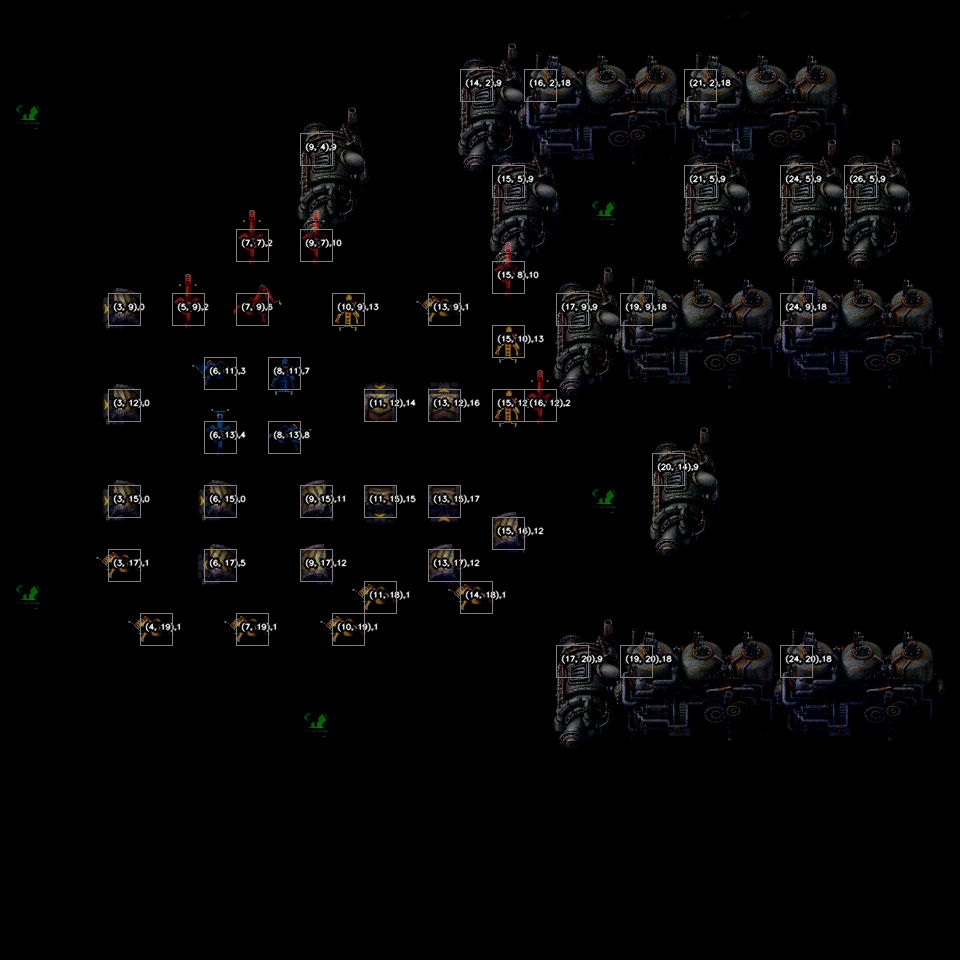

In [3]:
import cv2 as cv
import numpy as np
import cv2

import_or_reload('common')
import_or_reload('npext')
from common import *
from npext import *

gr = npext(cv2.imread('../tmp/test_get_tooltip1_gr.bmp')) | bgr2rgb()
fg = npext(cv2.imread('../tmp/test_get_tooltip1_fg1.bmp')) | bgr2rgb()
bg = npext(cv2.imread('../tmp/test_get_tooltip1_im1.bmp'))# | bgr2rgb()
mrks = npext(cv2.imread('../tmp/test_get_tooltip1_im2.bmp'))# | bgr2rgb()
# dis(gr.array)
fg1 = fg | posterize(5)
vl, hl, mvl, mhl, cell_width = get_grid(gr.array)
grd = grid(vl, hl)
mrks = get_marks(bg, mrks)
ents, ents1 = get_entity_coords_from_marks(mrks.array, vl, hl, cell_width)
map_c2e = get_cell_to_entity_map(ents1)
bmap = get_belt_map(vl, hl, cell_width, map_c2e, fg1.array)
dd = get_similarity_test_cache(grd, fg.array, bmap, map_c2e)
cc = get_classes(dd)
# print(cc)
# dis(mrks.array)
is_belt = is_belt_pred(bmap)
is_entity = is_entity_pred(map_c2e)
cls_map = dict()

for gc in iter_grid_cells(grd, fg.array, [is_partial_cell, is_nz_mask_low]):
    p = gc.loc
# for e in ents1:
#     p = grd[*e.top_left]
#     # e.
    # cv.rectangle(fg.array, p, p + (32,32), (128,128,128), 1, 8)
for grid_cell in iter_grid_cells(grd, fg.array, [is_entity, is_partial_cell, is_nz_mask_low, is_belt]):
    ij, p = tuple(grid_cell.idx), grid_cell.loc
    cls_map[ij] = get_image_class(dd, ij, cc)
    # putOutlinedText(fg.array, f'{ij},{cls_map[ij]}', p + (5,16), sz=0.25)
    putOutlinedText(fg.array, f'{ij},{cls_map[ij]}', p + (5,16), sz=0.25)
    cv.rectangle(fg.array, p, p + (32,32), (128,128,128), 1, 8)

dis(fg.array)

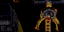

In [27]:
import cv2 as cv
import numpy as np
import cv2
from typing import List, Callable, Generator, Dict
import numpy as np
import numpy.typing as npt

import_or_reload('common')
import_or_reload('npext')
from common import *
from npext import *

l = list(dd.items())

img = hstack([l[23][1][0], l[4][1][0]])

dis(img)

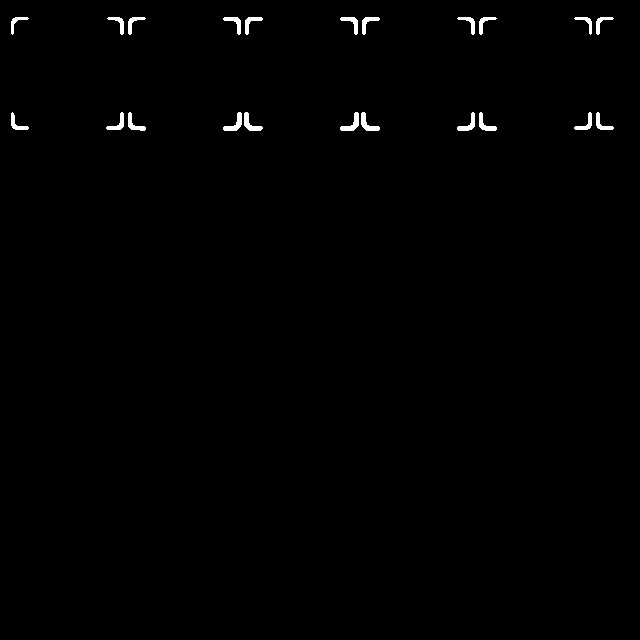

In [16]:
import cv2 as cv
import numpy as np
import_or_reload('common')
import_or_reload('npext')
from common import *
from npext import *

bg = npext(cv.imread('../tmp/test_get_tooltip1_im1.bmp')) | bgr2rgb()
mrks = npext(cv.imread('../tmp/test_get_tooltip1_im2.bmp')) | bgr2rgb()
res = npext(mrks.array.copy())

fg1, fg = get_foreground(bg.array, mrks.array)

get_marks
h, w, _ = bg.array.shape
# r = bg | bitwise_xor(mrks)

# | to_gray() | bin_threshold(35, 255) | erode(cv.MORPH_RECT, 3)
# cv.rectangle(r.array, (0,0), (w, h), (0,0,0), 3)

res = fg | to_gray() | bin_threshold(1, 255)
res = npext(remove_small_features(res.array, 50)) | erode(cv.MORPH_RECT, 3) | dilate(cv.MORPH_RECT, 3)
res = npext(remove_small_features(res.array, 50)) | erode(cv.MORPH_RECT, 5) | dilate(cv.MORPH_RECT, 3)
res = mrks | apply_mask(res) | to_gray() | bin_threshold(45, 255)
res = npext(remove_small_features(res.array, 20)) | dilate(cv.MORPH_ELLIPSE, 3)

dis(res.array)
# marks = comp | apply_mask(r) | gaussian_blur(1) | to_gray() | bin_threshold(100, 255)
# marks = npext(remove_small_features(marks.array, small_features_threshold))

# mrks = get_marks(bg, mrks)
# grid_img = npext(cv.imread('../tmp/test_get_tooltip1_gr.bmp')) | bgr2rgb()
# vl, hl, mvl, mhl, gcw = get_grid(grid_img.array)

# gg = grid(vl, hl)

# ents, ents1 = get_entity_coords_from_marks(mrks.array, vl, hl, gcw)

# map_c2e = get_cell_to_entity_map(ents1)
# for k, v in map_c2e.items():

#     putOutlinedText(res.array, str(v), gg[k] + (3,16), sz=0.35)

# print(map_c2e)
# dis(res.array, mrks.array)


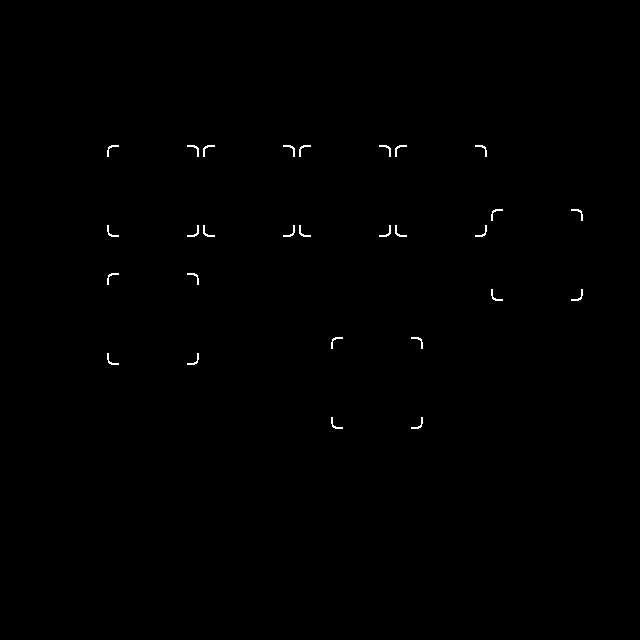

{(3, 4): array([3, 3]), (3, 8): array([3, 3]), (6, 4): array([3, 3]), (9, 4): array([3, 3]), (10, 10): array([3, 3]), (12, 4): array([3, 3]), (15, 6): array([3, 3])}


In [41]:
import cv2 as cv
import numpy as np
import_or_reload('common')
import_or_reload('npext')
from common import *
from npext import *

bg = npext(cv.imread('../tmp/test_get_tooltip1_im1.bmp')) | bgr2rgb()
mrks = npext(cv.imread('../tmp/test_get_tooltip1_im2.bmp')) | bgr2rgb()
grid_img = npext(cv.imread('../tmp/test_get_tooltip1_gr.bmp')) | bgr2rgb()

mrks1 = get_marks(bg, mrks)
vl, hl, mvl, mhl, gcw = get_grid(grid_img.array)
gg = grid(vl, hl)

# dis(mrks1.array)
g = grid(vl, hl)
def get_cell(im, g, gi, cell_width):
    return crop_image(im, Rect(*g[gi], cell_width, cell_width))
gw, gh, _ = g.shape
non_empty_cells = dict()
mrks2 = np.zeros_like(mrks1.array)
for i in range(gw):
    for j in range(gh):
        cell = get_cell(mrks1.array, g, (i,j), gcw)
        if np.count_nonzero(cell) != 0:
            non_empty_cells[(i,j)] = cell
            p = g[(i,j)]
            c = cv.copyMakeBorder(cell, 1, 1, 1, 1, cv.BORDER_CONSTANT, value=0)
            cc = (npext(c) | erode(cv.MORPH_ELLIPSE, 5)).array
            # dis(c, cc)
            ccc = cc[1:-1, 1:-1]
            mrks2[p[1]:p[1] + gcw, p[0]:p[0] + gcw] = ccc

            # break
# print(np.all(mrks1.array == mrks2))
dis(mrks2)
# print(non_empty_cells)
ents, ents1 = get_entity_coords_from_marks(mrks1.array, vl, hl, gcw)
map_c2e = get_cell_to_entity_map(ents1)
print(map_c2e)


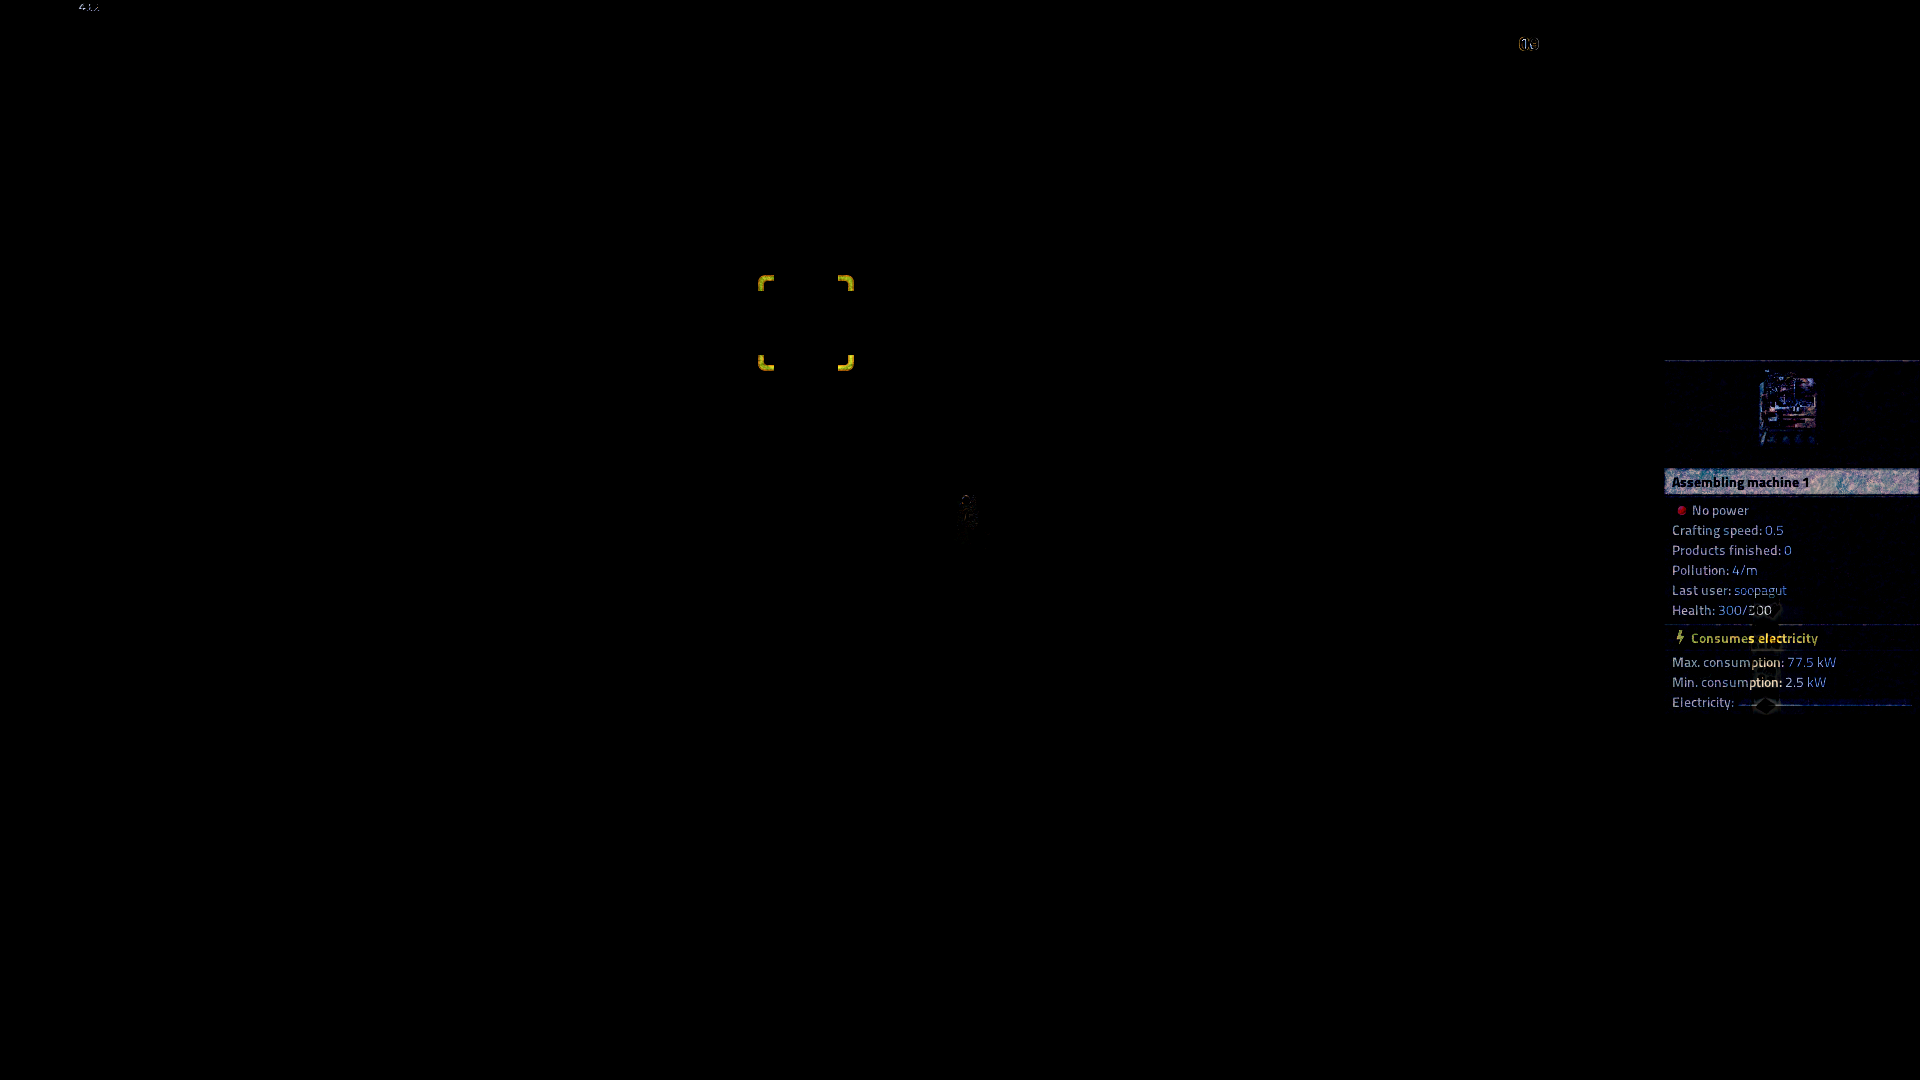

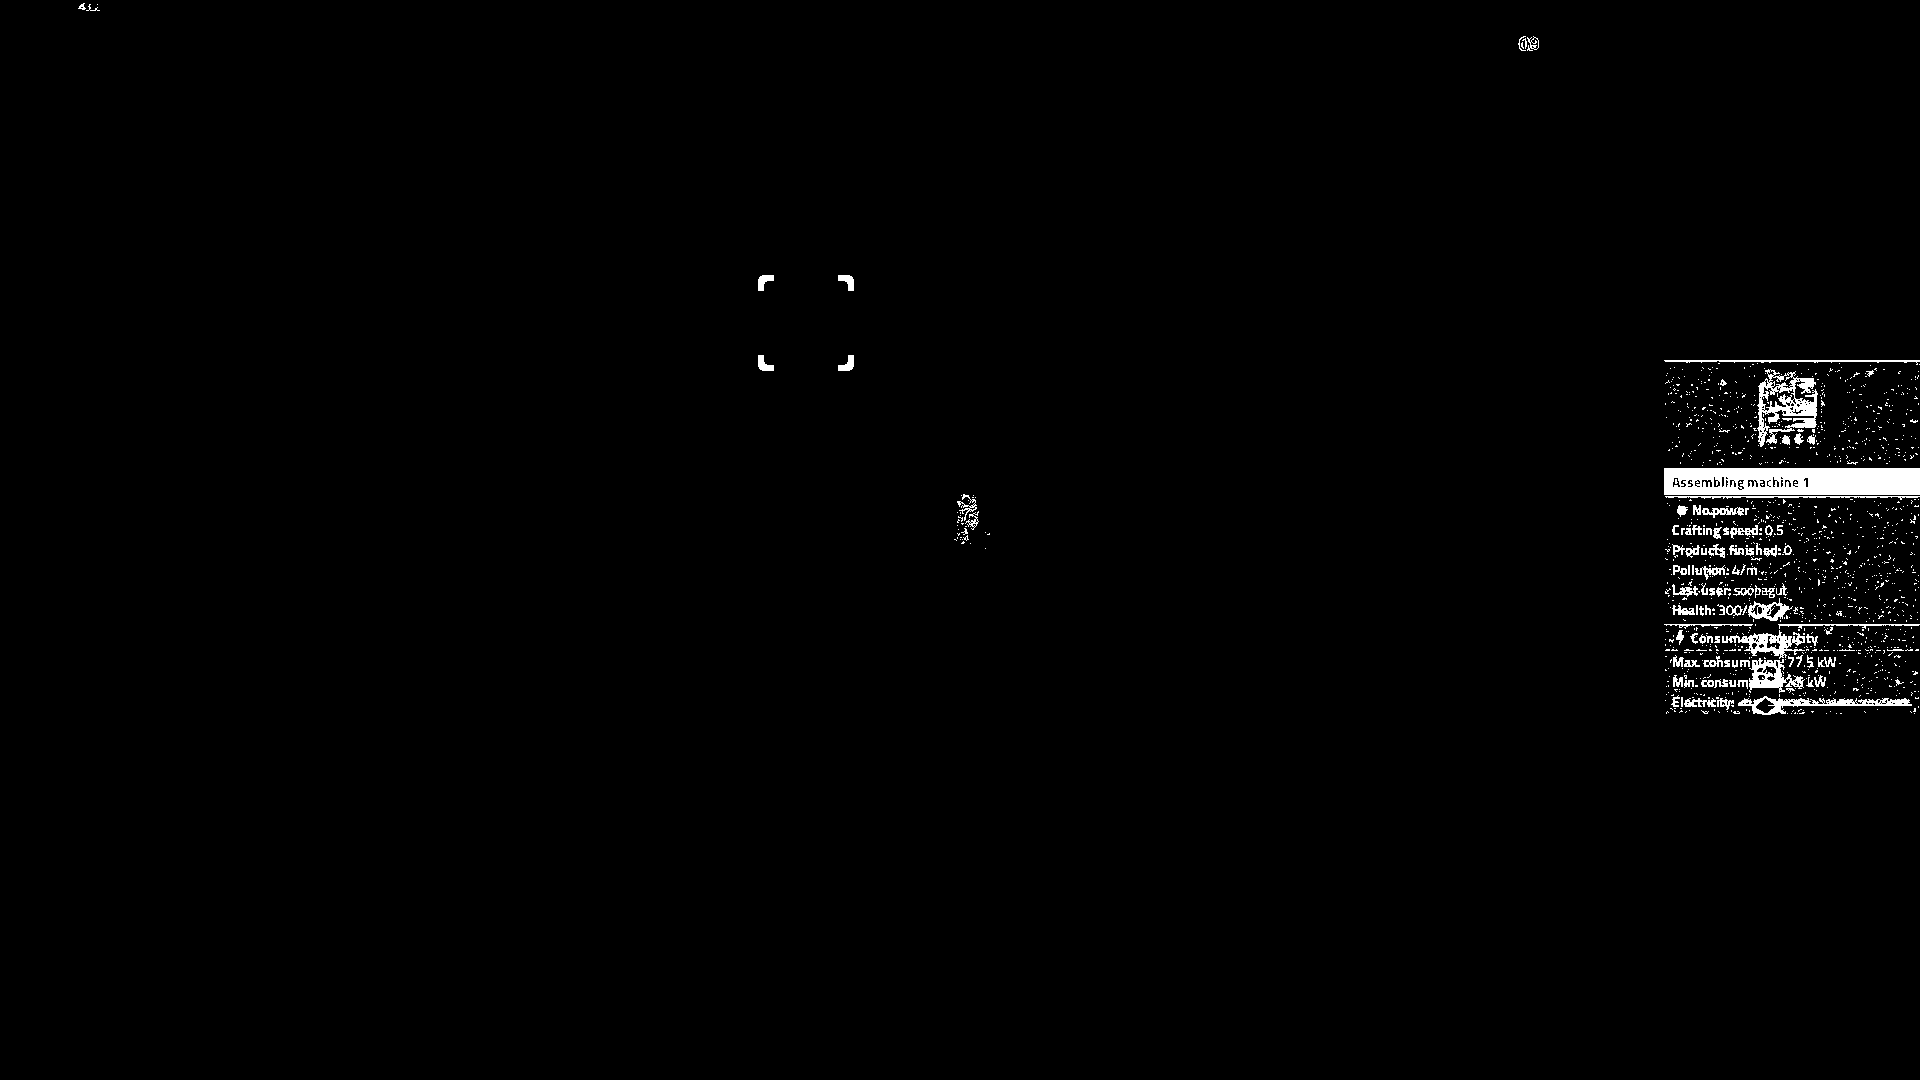

In [4]:
import cv2 as cv
import numpy as np
import_or_reload('common')
import_or_reload('npext')
from common import *
from npext import *

bg = npext(cv.imread('../tmp/test_get_tooltip1_ttim1.bmp')) | bgr2rgb()
tt = npext(cv.imread('../tmp/test_get_tooltip1_ttim2.bmp')) | bgr2rgb()
grid_img = npext(cv.imread('../tmp/test_get_tooltip1_gr.bmp')) | bgr2rgb()

vl, hl, mvl, mhl, gcw = get_grid(grid_img.array)
gg = grid(vl, hl)


comp = tt.array.astype(np.float32)
bg = bg.array.astype(np.float32)
fg = (comp - bg)
fg = np.clip(fg, 0, 255).astype(np.uint8)

binimg = npext(fg) | to_gray() |  bin_threshold(1, 255)

dis(fg, binimg.array)


In [22]:
from contextlib import contextmanager
import time

@contextmanager
def test():
    data_container = list()
    data_container.append('a')
    def pass_fun():
        return data_container
    yield pass_fun
    data_container.append('b')


with test() as pick_data:
    time.sleep(1.0)

print(pick_data())

a = np.array([1,2,3])
type(a) == np.ndarray

['a', 'b']


True

In [5]:
import inspect

def f():
    caller_frame = inspect.currentframe().f_back
    caller_name = caller_frame.f_code.co_name
    if caller_name == 'f1':
        caller_caller_frame = inspect.currentframe().f_back.f_back
        ccname = caller_caller_frame.f_code.co_name
        print(ccname, caller_name)
        pass
    pass

def f1():
    f()

def f2():
    
    f1()


f2()

f2 f1


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


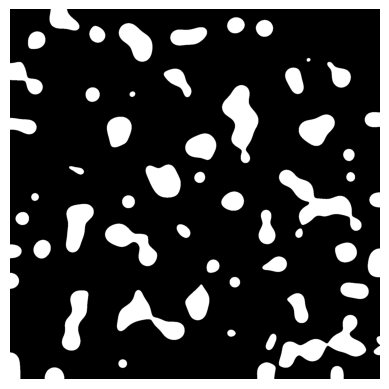

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2

# Create a blank canvas
width, height = 1600, 1600
canvas = np.zeros((height, width), dtype=np.uint8)

# Create random points for the blob
num_points = 170
x = np.random.randint(0, width, num_points)
y = np.random.randint(0, height, num_points)
r = np.random.randint(20, 50, num_points)

# Set the points to 1 to create the blob
for y_, x_, r_ in zip(y, x, r):

    cv2.circle(canvas, (y_,x_), r_, (255), -1)
canvas[y, x] = 255

# Apply Gaussian filter to make it smooth
canvas = gaussian_filter(canvas, sigma=25, )
_, canvas = cv2.threshold(canvas, 128, 255, cv2.THRESH_BINARY)
print(canvas)
cv2.imwrite('blob.png', canvas)
# Plot the result
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.show()

Label 1 is associated with Contour 56.
Label 2 is associated with Contour 55.
Label 3 is associated with Contour 54.
Label 4 is associated with Contour 53.
Label 5 is associated with Contour 52.
Label 6 is associated with Contour 51.
Label 7 is associated with Contour 50.
Label 8 is associated with Contour 49.
Label 9 is associated with Contour 48.
Label 10 is associated with Contour 47.
Label 12 is associated with Contour 45.
Label 13 is associated with Contour 44.
Label 14 is associated with Contour 43.
Label 15 is associated with Contour 42.
Label 16 is associated with Contour 41.
Label 17 is associated with Contour 40.
Label 18 is associated with Contour 39.
Label 19 is associated with Contour 38.
Label 20 is associated with Contour 37.
Label 21 is associated with Contour 36.
Label 22 is associated with Contour 35.
Label 23 is associated with Contour 34.
Label 24 is associated with Contour 33.
Label 25 is associated with Contour 32.
Label 26 is associated with Contour 31.
Label 27 

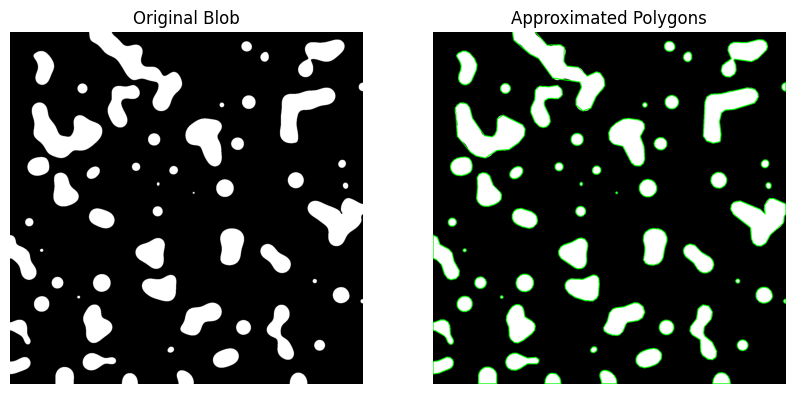

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2

# # Create a blank canvas
# width, height = 1000, 1000
# canvas = np.zeros((height, width), dtype=np.uint8)

# # Create random points for the blob
# num_points = 700
# x = np.random.randint(0, width, num_points)
# y = np.random.randint(0, height, num_points)

# # Set the points to 1 to create the blob
# canvas[y, x] = 255

# # Apply Gaussian filter to make it smooth
# sigma = 5.0  # Set sigma for Gaussian blur
# blob = gaussian_filter(canvas, sigma=sigma)
# _, blob = cv2.threshold(blob, 4, 255, cv2.THRESH_BINARY)


width, height = 1600, 1600
canvas = np.zeros((height, width), dtype=np.uint8)

# Create random points for the blob
num_points = 170
x = np.random.randint(0, width, num_points)
y = np.random.randint(0, height, num_points)
r = np.random.randint(20, 50, num_points)

# Set the points to 1 to create the blob
for y_, x_, r_ in zip(y, x, r):

    cv2.circle(canvas, (y_,x_), r_, (255), -1)
canvas[y, x] = 255

# Apply Gaussian filter to make it smooth
canvas = gaussian_filter(canvas, sigma=25, )
_, canvas = cv2.threshold(canvas, 128, 255, cv2.THRESH_BINARY)
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGRA)
blob = canvas

# Find connected components
num_labels, labels_im = cv2.connectedComponents(blob.astype(np.uint8))


# Find connected components
num_labels, labels_im = cv2.connectedComponents(blob.astype(np.uint8))

# Find contours of the blob
contours, _ = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Approximate the contours to a polygon
polygons = []
for contour in contours:
    # Approximate the contour to a polygon
    epsilon = 0.005 * cv2.arcLength(contour, True)  # 1% of the contour length
    approx_polygon = cv2.approxPolyDP(contour, epsilon, True)
    polygons.append(approx_polygon)

# Optionally, draw the approximated polygons on the original image
output_image = cv2.cvtColor(blob, cv2.COLOR_GRAY2BGR)  # Convert to BGR for coloring
for polygon in polygons:
    cv2.polylines(output_image, [polygon], isClosed=True, color=(0, 255, 0), thickness=3)

    # Step 3: Map labels to contours
label_to_contour_mapping = {}

for label in range(1, num_labels):  # label 0 is the background
    contour_pixels = np.where(labels_im == label)  # Find pixels corresponding to this label
    contour_points = np.array(list(zip(contour_pixels[1], contour_pixels[0])))  # Convert to (x, y) points

    # Iterate through contours to find which one matches the label
    for i, contour in enumerate(contours):
        # Check if any point of the contour is in the label's region
        if cv2.pointPolygonTest(contour, (contour_points[:,0].mean(), contour_points[:,1].mean()), True) >= 0:
            label_to_contour_mapping[label] = i  # Map label to contour index
            break  # Break as we found the matching contour

# Print the resulting mapping
for label, contour_index in label_to_contour_mapping.items():
    print(f"Label {label} is associated with Contour {contour_index}.")

# Display the original blob and the approximate polygons
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blob, cmap='gray')
plt.title('Original Blob')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Approximated Polygons')
plt.axis('off')

plt.show()


In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a binary blob (for example purposes)
# blob_img = np.zeros((500, 500), dtype=np.uint8)
# cv2.circle(blob_img, (250, 250), 100, 255, -1)  # Creating a circular blob
blob_img1 = cv2.imread('c1.png')
blob_img1 = cv2.cvtColor(blob_img1, cv2.COLOR_BGR2GRAY)

def find_and_stitch_polygons(blob_img, erosion_size, area_threshold):
    # Step 1: Find the initial contour
    contours, _ = cv2.findContours(blob_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if there are any contours found
    if not contours:
        return None
    
    stitched_polygons = []
    
    # Initial contour
    current_contour = contours[0]

    while True:
        # Step 2: Approximate the current contour to a polygon
        epsilon = 0.02 * cv2.arcLength(current_contour, True)  # Epsilon can be adjusted
        approx_polygon = cv2.approxPolyDP(current_contour, epsilon, True)
        
        # Add the polygon to the list
        stitched_polygons.append(approx_polygon)

        # Calculate the area and break if it's below the threshold
        area = cv2.contourArea(current_contour)
        print(area)
        if area < area_threshold:
            break
        
        # Step 3: Erode the original image to create a smaller blob
        eroded_blob = cv2.erode(blob_img, np.ones((erosion_size, erosion_size), np.uint8))
        
        # Step 4: Find contours again after erosion
        contours, _ = cv2.findContours(eroded_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Check again if any contours are found
        if not contours:
            break
        
        # Update current contour
        current_contour = contours[0]
    
    return stitched_polygons

# Parameters for erosion and area threshold
erosion_size = 5  # Size of erosion
area_threshold = 200  # Minimum area threshold for stopping

# Find and stitch polygons
stitched_polygons = find_and_stitch_polygons(blob_img1, erosion_size, area_threshold)

# Prepare to visualize the results
output_image = cv2.cvtColor(blob_img1, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization

# Draw all stitched polygons
if stitched_polygons:
    for polygon in stitched_polygons:
        cv2.polylines(output_image, [polygon], isClosed=True, color=(0, 255, 0), thickness=1)

# Show the resulting image with Matplotlib
plt.imshow(output_image)
plt.title("Stitched Polygons on Blob")
plt.axis('off')  # Turn off axis labels
plt.show()

43862.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0
40798.0


KeyboardInterrupt: 

<Figure size 1800x1200 with 0 Axes>

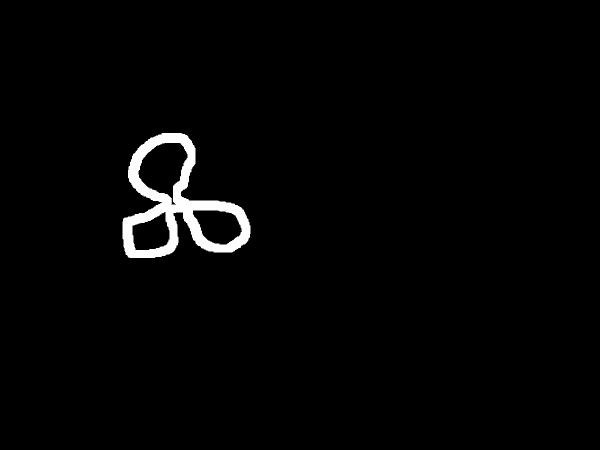

In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create an arbitrary blob (any shape)
blob_img = cv2.imread('c2.png')
blob_img = cv2.cvtColor(blob_img, cv2.COLOR_BGR2GRAY)

import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import img_as_ubyte
from skimage import filters

def step(img, sz):
    s = morphology.medial_axis(img)
    s = s.astype(np.uint8)
    _, s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY)
    s = cv2.dilate(s, np.ones((sz//2, sz//2), np.uint8)).astype(np.uint8)
    r = cv2.erode(img, np.ones((sz, sz), np.uint8)).astype(np.uint8)
    _, r = cv2.threshold(r, 0, 255, cv2.THRESH_BINARY)
    return np.bitwise_or(r, s)

# Create a simple binary image with a shape
binary_image = blob_img
# Optionally, use a more complex shape
# from skimage.draw import ellipse
# rr, cc = ellipse(50, 50, 25, 35, shape=binary_image.shape)
# binary_image[rr, cc] = 1
binary_image = cv2.resize(binary_image, None, fx=0.5, fy=0.5)
img = binary_image.copy()

# Display the original binary image
plt.figure(figsize=(18, 12))

for st in range(0):
    plt.subplot(2, 2, st + 1)
    plt.title(f'step {st}')
    plt.imshow(img, cmap='gray')
    img = step(img, 21)

# Show the figures
plt.show()


def reduce_step(binary_image, iters=25):
    s = morphology.thin(binary_image, max_num_iter=iters)
    s = s.astype(np.uint8)
    _, s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    s1 = cv2.morphologyEx(s, cv2.MORPH_OPEN, kernel, iterations=1)
    return s1


# s = reduce_step(binary_image, iters=5)
# dis(s)
# s1 = morphology.thin(binary_image, max_num_iter=5)
# s1 = s1.astype(np.uint8)
# _, s1 = cv2.threshold(s1, 0, 255, cv2.THRESH_BINARY)
# ss = cv2.bitwise_xor(binary_image, s)
sz = 10
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz, sz))
s = cv2.erode(binary_image, k).astype(np.uint8)
s1 = cv2.bitwise_xor(binary_image, s)

s = cv2.erode(s, k).astype(np.uint8)
s1 = cv2.bitwise_xor(binary_image, s)

dis(s1)

# p = s.copy()
# s = morphology.thin(s, max_num_iter=10)
# s = s.astype(np.uint8)
# _, s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# s1 = cv2.morphologyEx(s, cv2.MORPH_OPEN, kernel, iterations=1)

# # cv2.morphologyEx(s, )
# ss = cv2.bitwise_xor(s, s1)
# # sz = 5
# # s = cv2.dilate(s, np.ones((sz, sz), np.uint8)).astype(np.uint8)
# dis(ss)


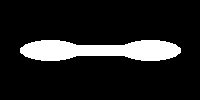

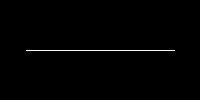

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image as PILImage
from skimage import morphology

def dis(*imgs):
    l = list(map(PILImage.fromarray, imgs))
    display(*l)



# Create a sample binary image (like a dumbbell)
image = np.zeros((100, 200), dtype=np.uint8)
cv2.ellipse(image, (50, 50), (30, 10), 0, 0, 360, 255, -1)  # Left circle
cv2.ellipse(image, (150, 50), (30, 10), 0, 0, 360, 255, -1)  # Right circle
cv2.rectangle(image, (70, 45), (130, 55), 255, -1)  # Bridge

s = morphology.thin(image)
s = s.astype(np.uint8)
_, s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY)


# Display the images
dis(image, s)


In [199]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create an arbitrary blob (any shape)
map_with_biters = cv2.imread('tmp/map.png')
# map_with_biters = cv2.cvtColor(map_with_biters, cv2.COLOR_BGR2RGB)
bin_map = map_with_biters[:,:,0]

import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import img_as_ubyte
from skimage import filters
from scipy.ndimage import gaussian_filter


def rgb2hsv(c):
    i = np.zeros(shape=(1,1,3), dtype=np.uint8)
    i[0,0] = c
    return cv2.cvtColor(i, cv2.COLOR_RGB2HSV)[0, 0]

def hsv2rgb(c):
    i = np.zeros(shape=(1,1,3), dtype=np.uint8)
    i[0,0] = c
    return cv2.cvtColor(i, cv2.COLOR_HSV2RGB)[0, 0]

def get_blue(img):
    cols = np.array([[13, 34, 40],
    [22, 43, 49],
    [21, 56, 67],
    [36, 71, 82]])
    h, w, _ = img.shape
    mask = np.zeros(shape=(h, w), dtype=np.uint8)
    for c in cols:
        cmask = cv2.inRange(img, c, c)
        mask = cv2.bitwise_or(cmask, mask)
    return mask



def get_red(img):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red_1 = np.array([0, 100, 100])
    upper_red_1 = np.array([10, 255, 255])
    lower_red_2 = np.array([160, 100, 100])
    upper_red_2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv_image, lower_red_1, upper_red_1)
    mask2 = cv2.inRange(hsv_image, lower_red_2, upper_red_2)
    red_mask = cv2.bitwise_or(mask1, mask2)
    high_intensity_mask = cv2.inRange(hsv_image[:, :, 2], 150, 255)
    final_mask = cv2.bitwise_and(red_mask, high_intensity_mask)
    _, m = cv2.threshold(final_mask, 1, 255, cv2.THRESH_BINARY)
    return m

'''
final_mask = get_red(map_with_biters)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (23, 23))

# Perform morphological opening
# opn = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
sigma = 15.0
opn = gaussian_filter(final_mask, sigma=sigma)
_, opn = cv2.threshold(opn, 25, 255, cv2.THRESH_BINARY)
opn1 = cv2.cvtColor(opn, cv2.COLOR_GRAY2BGR)
hl = cv2.bitwise_xor(map_with_biters, opn1)
hl = cv2.cvtColor(hl, cv2.COLOR_BGR2RGB)

map_with_biters = cv2.cvtColor(map_with_biters, cv2.COLOR_BGR2RGB)
map_with_biters = cv2.resize(map_with_biters, None, fx=0.25, fy=0.25)

bl = get_blue(map_with_biters)
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
bl = cv2.morphologyEx(bl, cv2.MORPH_CLOSE, k)
bl = cv2.cvtColor(bl, cv2.COLOR_GRAY2RGB)
# opn = cv2.resize(opn, None, fx=0.25, fy=0.25)
bl = cv2.bitwise_and(map_with_biters, bl)
# cv2.imwrite('tmp/opn.png', opn)

# dis(hl)

# r, g, b, a = map_with_biters[0,0]


# Find contours of the blob
contours, _ = cv2.findContours(opn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Approximate the contours to a polygon
polygons = []
for contour in contours:
    # Approximate the contour to a polygon
    ar = cv2.contourArea(contour)
    al = cv2.arcLength(contour, True)  # 1% of the contour length
    # np.power(al, 1/3)
    # np.power(al, 1/7)
    epsilon = 4 * np.power(al, 1/17)
    approx_polygon = cv2.approxPolyDP(contour, epsilon, True)
    polygons.append(approx_polygon)

# Optionally, draw the approximated polygons on the original image
output_image = cv2.cvtColor(opn, cv2.COLOR_GRAY2BGR)  # Convert to BGR for coloring
for polygon in polygons:
    cv2.polylines(output_image, [polygon], isClosed=True, color=(0, 255, 0), thickness=3)
    for p in polygon:
        cv2.circle(output_image, p[0], 5, (255, 0, 0), -1)
'''

def translate_calculate_restore(img, factor=0.25):
    img = cv2.resize(img, None, fx=factor, fy=factor)
    red_mask = get_red(img)
    sigma = 15.0
    red_mask = gaussian_filter(red_mask, sigma=sigma)
    _, red_mask = cv2.threshold(red_mask, 25, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    stats = {}
    for i, contour in enumerate(contours):
        ar = cv2.contourArea(contour)
        al = cv2.arcLength(contour, True)
        epsilon = 8 * np.power(al, 1/17)
        approx_polygon = cv2.approxPolyDP(contour, epsilon, True)
        approx_polygon = approx_polygon / factor
        polygons.append(approx_polygon)
        stats[i] = {'area': ar, 'arclen': al}
    return polygons, stats

poly, stats = translate_calculate_restore(map_with_biters, factor=0.25)

output_image = map_with_biters.copy()  # Convert to BGR for coloring
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
for polygon in polygons:
    cv2.polylines(output_image, [polygon], isClosed=True, color=(0, 255, 0), thickness=3)
    for p in polygon:
        x, y = p[0]
        print(x, y)
        cv2.circle(output_image, p[0], 5, (255, 0, 0), -1)
    break

# dis(output_image)
# cv2.imwrite('outputimg.png', output_image)

print(*(np.array([1,2,3])/2))


3374 1723
3357 1784
3364 1859
3387 1872
3456 1871
3493 1861
3506 1835
3498 1784
3513 1753
3511 1737
3456 1731
3423 1703
3393 1722
0.5 1.0 1.5


In [119]:
from PySide6.QtCore import QPoint

p = QPoint(1,2)
p.toTuple()

13, 34, 40
22, 43, 49

21, 56, 67
c = [36, 71, 82]

def rgb2hsv(c):
    i = np.zeros(shape=(1,1,3), dtype=np.uint8)
    i[0,0] = c
    return cv2.cvtColor(i, cv2.COLOR_RGB2HSV)[0, 0]

def hsv2rgb(c):
    i = np.zeros(shape=(1,1,3), dtype=np.uint8)
    i[0,0] = c
    return cv2.cvtColor(i, cv2.COLOR_HSV2RGB)[0, 0]

print(rgb2hsv(c))
print(hsv2rgb(rgb2hsv(c)))

[ 97 143  82]
[36 71 82]
